## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [11]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

## 티커(Ticker, Symbol) : 주식이나 상장된 금융 상품을 식별하기 위한 고유한 코드
* 고유성 : 상장된 기업이나 금융 상품은 모두 다른 티커를 가지고 중복되지 않음.
* 거래소별 차이 : 같은 회사라도 상장된 거래소에 따라 티커가 다를 수 있음

In [19]:
ticker = '005930.KS'
stock_data = yf.Ticker(ticker)

data = stock_data.history(period="5y")

print(data)

                                   Open          High           Low  \
Date                                                                  
2019-10-08 00:00:00+09:00  42333.947605  43306.125943  42068.808059   
2019-10-10 00:00:00+09:00  42599.092366  43482.890963  42422.332647   
2019-10-11 00:00:00+09:00  43306.133329  43703.842717  43129.373601   
2019-10-14 00:00:00+09:00  44189.933594  44455.073195  44057.363793   
2019-10-15 00:00:00+09:00  44101.548879  44366.688451  44101.548879   
...                                 ...           ...           ...   
2024-09-30 00:00:00+09:00  64200.000000  64300.000000  61500.000000   
2024-10-02 00:00:00+09:00  60500.000000  61900.000000  59900.000000   
2024-10-04 00:00:00+09:00  61000.000000  61700.000000  60500.000000   
2024-10-07 00:00:00+09:00  60200.000000  61900.000000  59500.000000   
2024-10-08 00:00:00+09:00  60000.000000  61000.000000  59900.000000   

                                  Close    Volume  Dividends  Stock Splits  

1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [31]:
df = pd.DataFrame(data)
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [68]:
df.shape

(1230, 7)

In [70]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1230.000000,1230.000000,1230.000000,1230.000000,1.230000e+03,1230.000000,1230.0
mean,64375.027185,64928.462205,63770.602367,64311.214466,1.707282e+07,6.830894,0.0
std,11057.827894,11104.969121,10975.648939,11027.167630,8.773943e+06,69.877196,0.0
min,37891.940404,38736.948465,37625.105964,37802.992188,0.000000e+00,0.000000,0.0
25%,55090.693049,55726.001319,54672.773176,55138.050781,1.181929e+07,0.000000,0.0
50%,66186.411799,66603.953964,65791.891238,66146.757812,1.520671e+07,0.000000,0.0
75%,73515.217867,74022.371640,72737.135514,73357.058594,2.036618e+07,0.000000,0.0
max,88500.000000,90065.718407,87100.000000,87800.000000,9.030618e+07,1932.000000,0.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1230 entries, 2019-10-08 00:00:00+09:00 to 2024-10-08 00:00:00+09:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1230 non-null   float64
 1   High          1230 non-null   float64
 2   Low           1230 non-null   float64
 3   Close         1230 non-null   float64
 4   Volume        1230 non-null   int64  
 5   Dividends     1230 non-null   float64
 6   Stock Splits  1230 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 76.9 KB


## 주가 정보 attribute 정리

### 1. Open (시가)
시가(Open)는 해당 거래일에서 **주식 시장이 열릴 때 처음으로 체결된 가격**을 의미합니다.  
즉, 주식이 거래를 시작할 때의 가격이며, 해당 주식의 당일 주가 변동의 출발점으로 볼 수 있습니다.

---

### 2. High (고가)
고가(High)는 해당 거래일 동안 **주식이 기록한 가장 높은 가격**을 나타냅니다.  
주식이 거래되는 다양한 가격 변동이 있을 수 있지만, 그중 가장 높은 가격을 고가라고 합니다.

---

### 3. Low (저가)
저가(Low)는 해당 거래일 동안 **주식이 기록한 가장 낮은 가격**을 의미합니다.  
주식이 거래되는 동안 형성된 가격 중 가장 낮은 가격을 저가라고 합니다.

---

### 4. Close (종가)
종가(Close)는 해당 거래일에서 **주식 시장이 종료될 때 마지막으로 체결된 가격**을 의미합니다.  
종가는 일반적으로 당일 주식 가격을 평가할 때 중요한 기준으로 사용됩니다.

---

### 5. Volume (거래량)
거래량(Volume)은 해당 거래일 동안 **거래된 주식의 총 수량**을 나타냅니다.  
거래량이 많을수록 해당 주식이 활발하게 거래되었음을 의미하며, 주식의 유동성과 시장의 관심도를 반영하는 중요한 지표입니다.

---

### 6. Dividends (배당금)
배당금(Dividends)은 **주식 보유자에게 지급된 배당금의 금액**을 의미합니다.  
일부 회사는 이익의 일부를 주주들에게 배당금으로 지급하며, 이 배당금은 주당 지급액을 기준으로 표시됩니다. 배당금 지급일을 반영해 해당 데이터에 기록됩니다.

---

### 7. Stock Splits (주식 분할)


주식 분할(Stock Splits) 은 **기업이 기존의 주식을 여러 주식으로 나누는 기업 활동**을 의미합니다.  
주식 분할은 주식의 유동성을 높이기 위해 주식 수를 증가시키지만, 주식의 총 가치는 변하지 않습니다.  
예를 들어, 2대1 주식 분할은 한 주식을 두 주식으로 나누는 것을 의미하며, 기존 주식 가격이 절반으로 감소하는 반면 주식 수는 두 배로 늘어납니다.
기존 주식 가격이 절반으로 감소하는 반면 주식 수는 두 배로 늘어납니다.


## 시간이 별도의 column으로 나타나지 않고 인덱스에 포함됨.
### <u>인덱스</u>는 주로 행(<u>데이터 튜플 단위로</u>) 식별하는 데 사용된다.

### 인덱스 설정하는 방법
```python
df.set_index('Date', inplace=True) 
```

### 여러 인덱스값 참조
```python
df.loc[[인덱스1],[인덱스n]]
```

### 인덱스를 사용한 슬라이싱
```python
df.loc[인덱스_start : 인덱스_end])
```

### 조건을 사용한 인덱스 참조
df[인덱스] 연산자 피연산자


### <u>열</u>은 주로 열(<u>특정 속성이나 값</u>)을 식별하는 데 사용된다.


### 단일 열 참조 (대괄호 표기법)
* #### 방법1
```python
df[열]
```

* #### 방법2
```python
df.열
```


### 여러 열 참조
```python
df[[열1, 열n]])
```

#### 열에 조건을 걸어서 참조 : 인덱스와 유사

In [63]:
print(df.index)

DatetimeIndex(['2019-10-08 00:00:00+09:00', '2019-10-10 00:00:00+09:00',
               '2019-10-11 00:00:00+09:00', '2019-10-14 00:00:00+09:00',
               '2019-10-15 00:00:00+09:00', '2019-10-16 00:00:00+09:00',
               '2019-10-17 00:00:00+09:00', '2019-10-18 00:00:00+09:00',
               '2019-10-21 00:00:00+09:00', '2019-10-22 00:00:00+09:00',
               ...
               '2024-09-23 00:00:00+09:00', '2024-09-24 00:00:00+09:00',
               '2024-09-25 00:00:00+09:00', '2024-09-26 00:00:00+09:00',
               '2024-09-27 00:00:00+09:00', '2024-09-30 00:00:00+09:00',
               '2024-10-02 00:00:00+09:00', '2024-10-04 00:00:00+09:00',
               '2024-10-07 00:00:00+09:00', '2024-10-08 00:00:00+09:00'],
              dtype='datetime64[ns, Asia/Seoul]', name='Date', length=1230, freq=None)


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

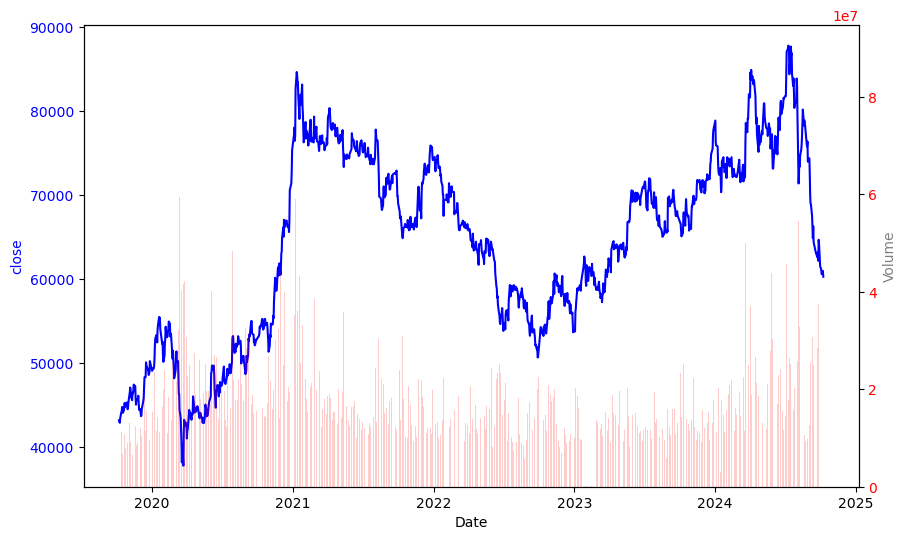

In [133]:
fig, ax1 = plt.subplots(figsize=(10,6))

# 종가 시각화
ax1.plot(df.index, df['Close'], color = 'blue', label = 'Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

#거래량 시각화
ax2 = ax1.twinx()
ax2.bar(df.index, df['Volume'], color = 'red', alpha = 0.2, label = 'Volume')
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='red')


1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

### 주가 변동 분석 
2020년 말부터 2021년 초까지 주가가 큰 상승이 있었음.

2022년 초에 급격한 하락이 있음.

--- 

### 주가와 거래량의 상관관계
주가 상승 시 거래량이 증가하는 경우는 강한 매수세를, 주가 하락 시 거래량이 증가하는 경우는 강한 매도세를 의미할 수 있음.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

정상성 : 시간이 지남에 따라 시계열 데이터의 통계적 성질이 일정하게 유지되는 상태를 의미. 즉 평균, 분산, 자기상관이 시간에 관계없이 일정한 상태. 이는 과거의 데이터를 통해 미래의 패턴을 예측할 수 있다는 가능성을 시사.

정상성을 검증해야 하는 이유 : 만약 데이터가 정상성이 없는 비정상 시계일이라면, 예측 성능이 떨어질 수 있음.

비정상성을 해결하는 방법
차분(Differencing) : 이전 시점과의 차이를 계산. 미분과 유사함.
이차 차분 : 두 번 미분하는 것과 비슷함.


로그 변환(Logarithmic Transformation) : 데이터의 스케일을 줄일 수 있음.

이동 평균(Moving Average) : 각 시점의 값을 그 시점과 그 전후 일정 기간의 평균값으로 대체하여 단기적 변동성 감소.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [147]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])  # ADF 통계량
print('p-value: %f' % result[1])  # p-value
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))  # 임계값

ADF Statistic: -2.162090
p-value: 0.220291
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


2.3 ADF Test 결과를 해석하세요.

ADF 통계량이 임계값들에 비해 높으므로 데이터가 비정상성을 띈다고 간주할 수 있다.

### ADF 테스트 정리

1. ADF 테스트의 목적
ADF 테스트는 데이터가 비정상성(Non-stationarity)을 가지고 있는지 또는 정상성을 가지고 있는지를 결정하기 위한 검정입니다. 시계열 데이터가 정상성을 띠지 않으면 예측 모델의 성능이 떨어질 수 있기 때문에, 데이터를 정상성 상태로 만들기 위한 중요한 도구입니다.

2. ADF 테스트의 가설 설정
ADF 테스트는 **귀무가설(H₀)**과 **대립가설(H₁)**로 나뉩니다.
귀무가설(H₀): 시계열 데이터가 **비정상성(Non-stationary)**을 가지고 있다. 즉, 단위근(Unit Root)이 존재한다는 가정입니다.
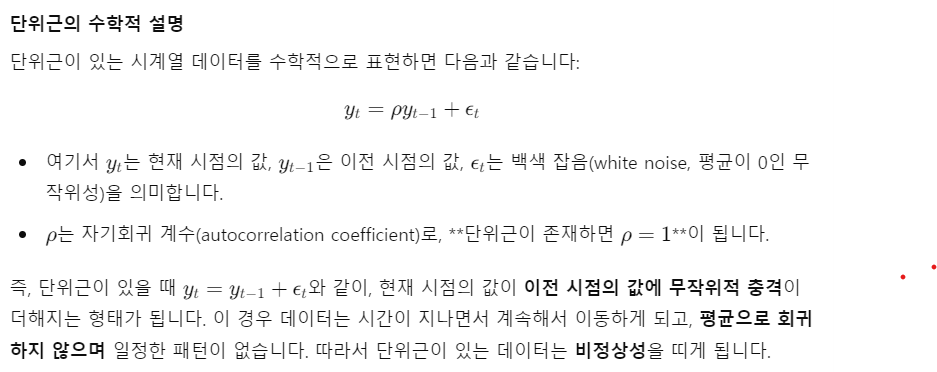 
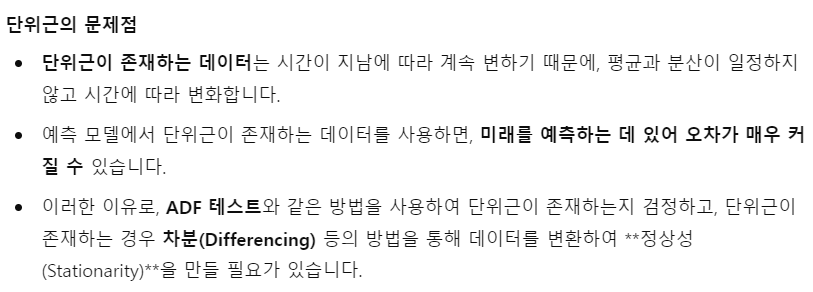
대립가설(H₁): 시계열 데이터가 **정상성(Stationary)**을 띤다. 즉, 단위근이 존재하지 않는다는 가정입니다.
3. ADF 테스트의 결과 해석
ADF 테스트의 결과로 p-value를 얻을 수 있는데, 이 값에 따라 귀무가설을 기각할지 여부를 결정할 수 있습니다.

p-value < 0.05: 귀무가설을 기각할 수 있습니다. 즉, 데이터가 정상성을 띤다고 결론을 내릴 수 있습니다.
p-value >= 0.05: 귀무가설을 기각할 수 없습니다. 즉, 데이터가 비정상성을 띤다고 결론을 내릴 수 있습니다.
ADF 테스트는 p-value 외에도 ADF 통계량, 임계값(critical value) 등을 제공합니다. ADF 통계량이 임계값보다 작으면 정상성을 가지는 것으로 판단할 수 있습니다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

## ACF(Autocorrealtion Function) : 시계열 데이터에서 시간 지연이 있을 때 이전 값과 현재 값의 상관관계를 측정하는 함수.

### ACF의 특징:
* 모든 시차에 대한 상관관계를 측정합니다. 즉, 시차 1, 2, 3, ... 등 여러 시차에 대해, 해당 시점의 값이 얼마나 과거 시점의 값과 관련이 있는지를 측정합니다.
* 직접적인 상관관계뿐만 아니라 간접적인 상관관계까지 모두 포함합니다. 예를 들어, 시차 3에서의 상관관계는 시차 1과 시차 2의 상관관계를 포함한 전체적인 상관관계를 나타냅니다.
* 간접적인 상관관계까지 포함하기 때문에 상관관계가 길게 지속되는 경우가 많습니다.

### ACF 해석:
* ACF 값이 1에 가까우면 강한 양의 상관관계가 있으며, 과거 값이 현재 값에 강하게 영향을 미친다는 의미입니다.
* ACF 값이 -1에 가까우면 강한 음의 상관관계가 있다는 뜻입니다. 과거 값이 현재 값에 반대되는 영향을 미친다는 의미입니다.
*  ACF 값이 0에 가까우면 자기상관이 거의 없다는 의미로, 과거 데이터와 현재 데이터 간에 특별한 상관관계가 없음을 나타냅니다.


## PACP(Partial Autocorrelation Function) : 특정 시차에서의 직접적인 상관관계만을 측정. 즉 이전 시차들의 영향을 제거한 후, 해당 시차와 현재 시차 간의 순수한 상관관계를 계산한다.

### PACF의 특징:
* 시차 k에서의 직접적인 상관관계를 측정합니다. 이를 통해 간접적인 상관관계를 제거하고, 특정 시차에서만 순수하게 현재 값에 얼마나 영향을 미치는지를 계산합니다.
* 간접적인 영향을 제거하기 때문에, 시차가 증가할수록 상관관계가 급격히 감소할 수 있습니다.

### PACF 해석:
* PACF 값이 1에 가까우면 해당 시차에서 과거와 현재 간에 강한 양의 상관관계가 있음을 의미합니다.
* 0에 가까우면 해당 시차에서 과거와 현재 간의 상관관계가 거의 없음을 나타냅니다.
* PACF 값은 특정 시차에서의 순수한 상관관계만을 보여주기 때문에, ACF와 달리 간접적인 영향을 제거한 상관관계를 확인할 수 있습니다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

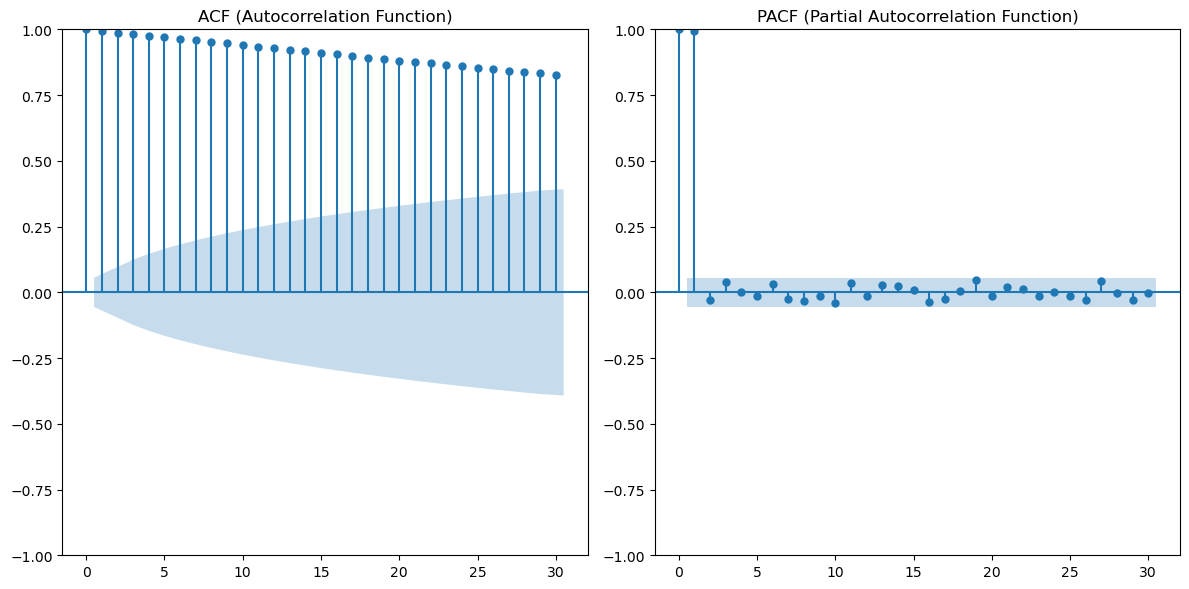

In [162]:
close_prices = df['Close']


plt.figure(figsize=(12, 6))


plt.subplot(121)
plot_acf(close_prices, ax=plt.gca(), lags=30)
plt.title('ACF (Autocorrelation Function)')

plt.subplot(122)
plot_pacf(close_prices, ax=plt.gca(), lags=30)
plt.title('PACF (Partial Autocorrelation Function)')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

### ACF 그래프 해석
1. 시차 1에서 ACF값이 1에 가까움: 즉 이전 시점과 현재 시점이 매우 유사한 패턴을 보임.
2. 모든 시차에서 ACF가 천천히 감소 : 데이터가 시간이 지남에 따라 지속적으로 자기상관을 가지고 있음.
3. ACF값이 시차가커져도 거의 0에 수렴되지 않고 유지 : 시계열 데이터에 추세가 존재하거나 장기적인 자기상관이 있다는 뜻.

### PACF 그래프 해석
1. 시차 1에서 PACF값이 1에 가까움 : 바로 이전 시점과 현재 시점의 상관관계가 매우 큼.
2. 시차 2 이후로 급격한 감소 : 

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

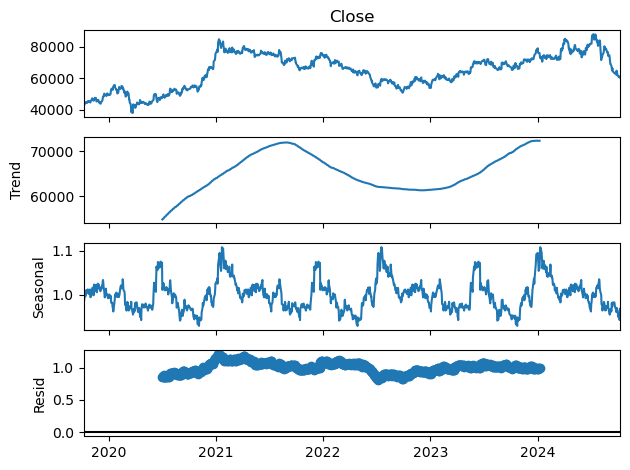

In [169]:
result = seasonal_decompose(close_prices, model='multiplicative', period=365)
result.plot()
plt.show()

2.8 위 결과를 해석하세요.

### 추세
시계열 데이터의 장기적인 방향성을 나타내며, 여기서는 주가가 상승과 하락을 반복하며 비교적 장기적인 흐름을 보이는 것을 확인할 수 있습니다.
### 계절성
일정한 주기로 반복되는 패턴을 보여줍니다. 이 그래프에서는 주가가 일정 주기마다 비슷한 패턴을 반복하는 모습을 볼 수 있습니다. 주가의 계절성은 약 1년 주기로 변동하는 것처럼 보입니다.
### 잔차
추세와 계절성을 제거한 후 남은 불규칙한 성분을 보여줍니다. 즉 예측 불가능한 요인을 나타냅니다. 이 잔차 그래프가 비교적 평탄하게 유지되고 있으며 큰 변동이 없다는 점에서, 모델이 계절성과 추세를 적절하게 분리한 것으로 보입니다.


## 시계열 데이터를 분해할 때 사용하는 두 가지 모델

### Multiplicative 모델
* 데이터의 구성 요소들이 비선형적인 관계를 가지는 경우에 적합
* 데이터의 변동성(계절성 패턴)이 시간에 따라 달라질 때
* 계절성 패턴의 크기가 데이터 값에 비례하여 커지거나 작아질 때
* 데이터의 변동 폭이 값의 크기에 따라 변동하는 비선형적일 때
* $$ y(t)=Trend(t)×Seasonality(t)×Residual(t) $$ 
> $$ Trend(t) $$ : 추세
> $$ Seasonality(t) $$ : 계절성
> $$ Residual(t) $$ : 잔차 

### Additive 모델
* 데이터의 구성 요소들이 선형적인 관계를 가질 때 적합
* 데이터의 변동성(계절성 패턴)이 시간에 따라 일정할 때.
* 계절성 패턴의 크기가 데이터 값과 무관하게 일정할 때.
* 데이터의 추세와 계절성이 서로 독립적으로 더해지는 관계일 때.
* $$ y(t)=Trend(t)+Seasonality(t)+Residual(t) $$
> $$ Trend(t) $$ : 추세
> $$ Seasonality(t) $$ : 계절성
> $$ Residual(t) $$ : 잔차 

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분은 이전 시점과의 차이를 계산하는 방법입니다. 데이터가 추세를 가질 경우, 한 시점과 그 이전 시점 간의 차이를 계산하면 그 추세가 제거될 수 있습니다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

ADF Statistic: -25.611050049150055
p-value: 0.0
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


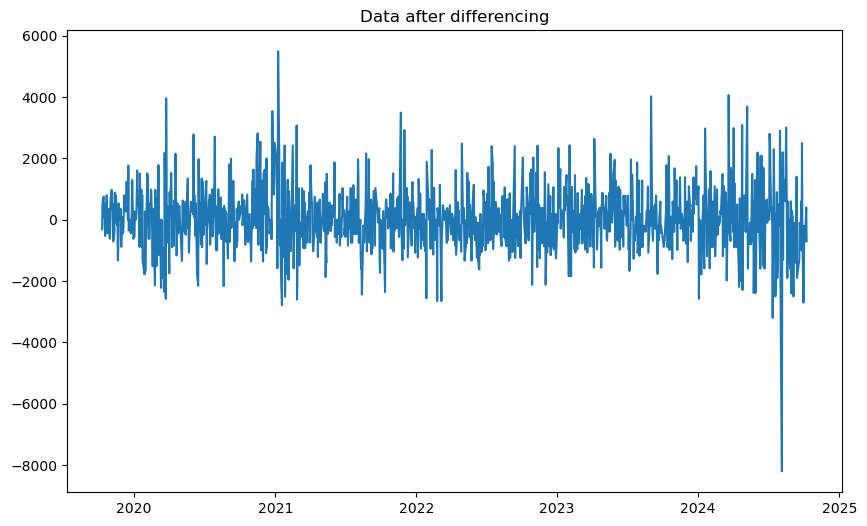

In [189]:
# 1차 차분 수행
diff_data = close_prices.diff().dropna()

# ADF 테스트 수행
adf_result = adfuller(diff_data)

# ADF 테스트 결과 출력
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.3f}")

# 1차 차분 데이터 시각화
plt.figure(figsize=(10,6))
plt.plot(diff_data)
plt.title('Data after differencing')
plt.show()

2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

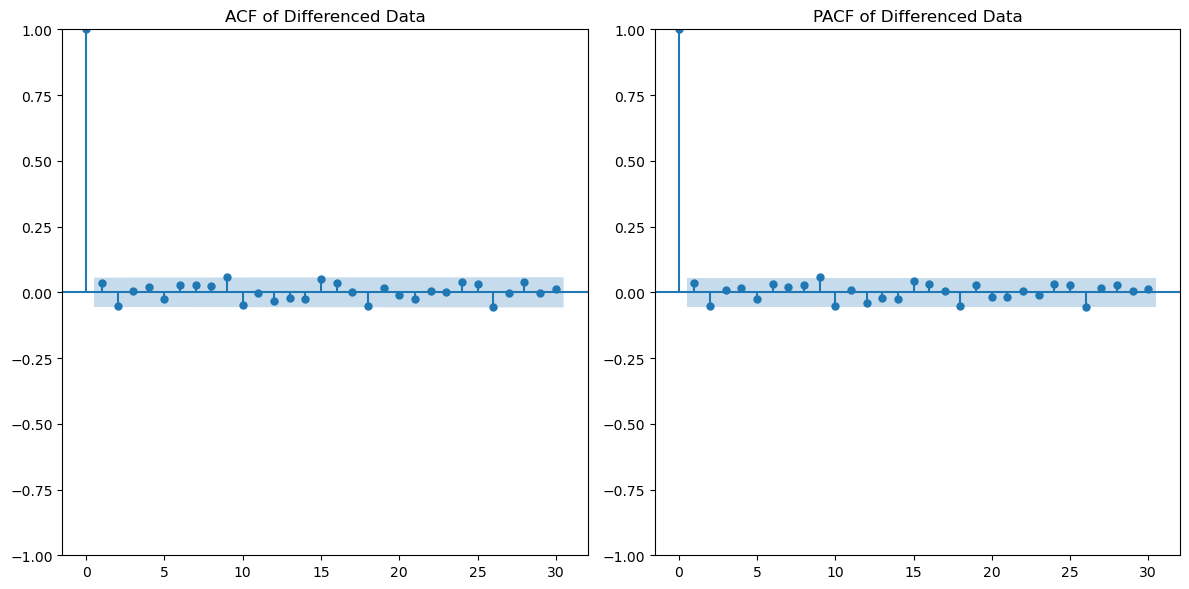

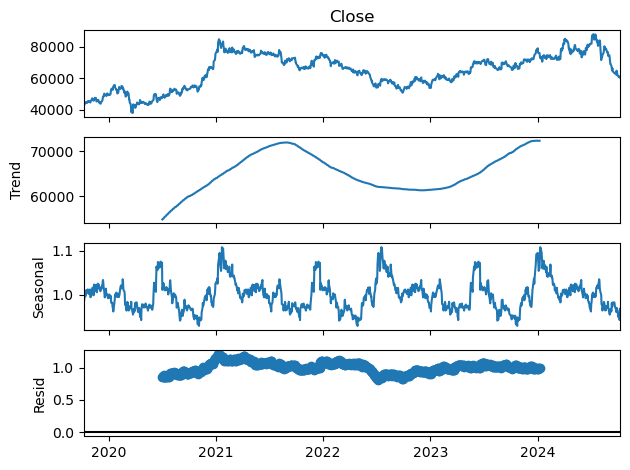

In [191]:
plt.figure(figsize=(12, 6))

# ACF 그래프
plt.subplot(121)
plot_acf(diff_data, ax=plt.gca(), lags=30)
plt.title('ACF of Differenced Data')

# PACF 그래프
plt.subplot(122)
plot_pacf(diff_data, ax=plt.gca(), lags=30)
plt.title('PACF of Differenced Data')

plt.tight_layout()
plt.show()

# 계절성 분해
result_original = seasonal_decompose(close_prices, model='multiplicative', period=365)

result_original.plot()
plt.show()

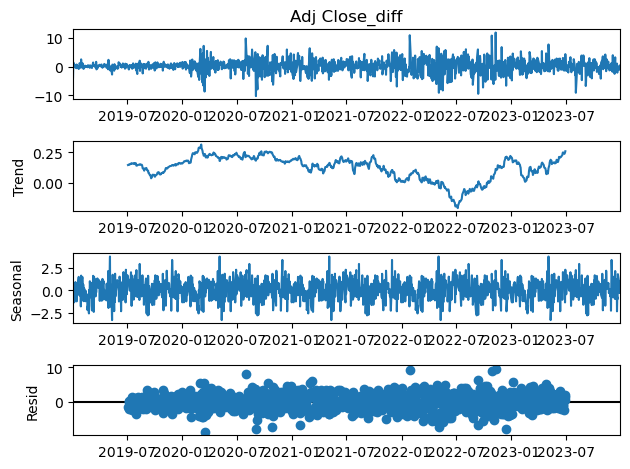

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [193]:
from statsmodels.tsa.arima.model import ARIMA

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

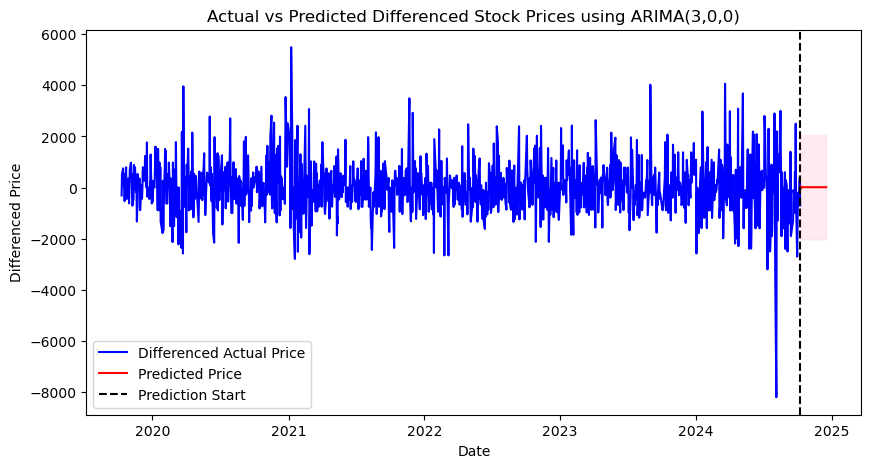

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1229
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -10276.977
Date:                Tue, 08 Oct 2024   AIC                          20563.953
Time:                        22:38:41   BIC                          20589.523
Sample:                             0   HQIC                         20573.574
                               - 1229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8993     29.717      0.468      0.640     -44.345      72.143
ar.L1          0.0363      0.023      1.612      0.107      -0.008       0.080
ar.L2         -0.0523      0.026     -2.004      0.045      -0.103      -0.001
ar.L3          0.0075      0.025      0.302      0.763      -0.041       0.056
sigma2      1.075e+06   2.74e+04     39.299      0.000    1.02e+06    1.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1007.47
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [217]:
model = ARIMA(diff_data, order=(3, 0, 0))  # d = 0 (차분이 미리 되었으므로)
model_fit = model.fit()

model_fit_summary = model_fit.summary()

forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(diff_data.index, diff_data, label='Differenced Actual Price', color='blue')
plt.plot(pd.date_range(start=diff_data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=diff_data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=diff_data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Differenced Stock Prices using ARIMA(3,0,0)')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

model_fit_summary

In [195]:
model = ARIMA(data['Close'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1230
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -10286.943
Date:                Tue, 08 Oct 2024   AIC                          20583.885
Time:                        22:34:46   BIC                          20609.459
Sample:                             0   HQIC                         20593.507
                               - 1230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.431e+04   5383.360     11.946      0.000    5.38e+04    7.49e+04
ar.L1          1.0344      0.022     46.366      0.000       0.991       1.078
ar.L2         -0.0879      0.034     -2.609      0.009      -0.154      -0.022
ar.L3          0.0497      0.026      1.919      0.055      -0.001       0.100
sigma2      1.071e+06   2.62e+04     40.935      0.000    1.02e+06    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               963.16
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.09
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""